In [5]:
import pickle
import numpy as np

rho=0.05
G = 0
with open("results/zeta_optim_hmm_12.pickle", "rb") as f:
    data:dict = pickle.load(f)
    p_vals = list(data[list(data.keys())[11]]["zeta"].values())
for i in range(len(p_vals)):
    area = np.pi * rho * (((i+1) * 10)**2 - (i*10)**2)
    G += rho * area * p_vals[i]

print(G)

0.04777344352226343


In [1]:
import numpy as np
import optuna
from functools import partial
import math
import pickle
import copy

from main_simulation import run_monte_carlo_simulation
from utils import SimulationParameters, overall_entropy
from environment import DTMC, NodeDistribution
from hmm_joint_prob import run_hmm_simulation

def objective(trial:optuna.Trial, params:SimulationParameters):
    local_params = copy.deepcopy(params)
    lower = 0
    upper = 5e-4
    value = trial.suggest_float("zeta_last", lower, upper)
    zeta = [upper]*(local_params.K-1)
    zeta.append(value)
    local_params.zeta = np.array(zeta)

    # using Monte Carlo simulation
    # entropy, _ = run_monte_carlo_simulation(local_params, 10000, 100, seed=0, zeta_bucket=True) # fix the seed to actually optimize the zeta

    # using formulas and averaging 10 different topologies
    #dtmc = DTMC(local_params.q, local_params.eta)
    NUM_RUNS = 15
    entropies = np.empty(NUM_RUNS, dtype=float)
    for j in range(NUM_RUNS):
        #node_dist = NodeDistribution(
        #    rho=local_params.rho,
        #    unit_radius=local_params.R_unit,
        #    K=local_params.K,
        #    zeta=zeta,
        #    alpha=local_params.alpha,
        #    beta=local_params.beta,
        #    seed=j,
        #    zeta_bucket=True,
        #    fixed_nodes_per_region=True
        #)
        # entropy, _ = run_monte_carlo_simulation(local_params, 10000, 100, seed=0, zeta_bucket=True) # fix the seed to actually optimize the zeta
        #entropy = overall_entropy(A=dtmc.A,
        #                          pi=dtmc.pi,
        #                          K=local_params.K,
        #                          R_unit=local_params.R_unit,
        #                          alpha=local_params.alpha,
        #                          m=len(node_dist),
        #                          zeta=node_dist.tx_probabilities,
        #                          epsilon=local_params.epsilon,
        #                          prob_per_bucket=zeta,
        #                          max_delta_considered=10000)
        _, entropy, _, _, _ = run_hmm_simulation(local_params, 10000, fixed_nodes_per_region=True, seed=j)
        entropies[j] = entropy
        trial.report(entropies[j], j)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(entropies)

if __name__ == "__main__":
    initial_params = SimulationParameters(
        q=0.005,
        eta=1,
        zeta=5e-4, # Example: list of base probabilities. NodeDistribution will use this.
        epsilon=0.1,
        rho=0.05,
        m_override=None,
        K=2, # Initial K for the first plot
        alpha=0.02,
        beta=0, # Default beta, will be overridden in the loop
        R_unit=10
    )
    initial_params.m = math.floor(initial_params.rho * np.pi * (initial_params.K*initial_params.R_unit)**2)
    wrapped_objective = partial(objective, params=initial_params)

    results = {}

    last_best_params = None
    for k in range(13, 15):
        current_params = copy.deepcopy(initial_params)
        current_params.K = k
        current_params.m = math.floor(current_params.rho * np.pi * (current_params.K*current_params.R_unit)**2)
        wrapped_objective = partial(objective, params=current_params)

        # call optuna
        study = optuna.create_study(direction="minimize", 
                                    #sampler=optuna.samplers.RandomSampler(), 
                                    pruner=optuna.pruners.MedianPruner()
                                    )
        # warm start the optimization
        values_to_try = [0, 5e-4, 5e-5, 5e-6, 5e-7, 5e-8, 5e-9]
        initial_guesses = {f"params_{n}": {f"zeta_last": val} for n, val in enumerate(values_to_try)}
        initial_guesses["last_best"] = last_best_params if last_best_params is not None else {f"zeta_{i}":9e-5 for i in range(k)}
        for params in initial_guesses.values():
            study.enqueue_trial(params)

        # start the optimization
        if k < 9:
            study.optimize(wrapped_objective, n_trials=200, n_jobs=2)
        else:
            study.optimize(wrapped_objective, n_trials=200, n_jobs=2)
        # compute the entropy for the fixed zeta case zeta = 1e-4
        if isinstance(initial_params.zeta, float):
            current_params.zeta = np.array([initial_params.zeta] * k)
        _, entropy, _, _, _ = run_hmm_simulation(current_params, 10000, seed=0, fixed_nodes_per_region=True)
        # get the best parameters and save them with the best objective
        results[k] = {"zeta": study.best_params,
                      "entropy_opt": study.best_value,
                      "entropy_same_z": entropy
                      }
        last_best_params = study.best_params
        last_best_params[f"zeta_{k}"] = 0
        
    print(results)

c:\ProgramData\mambaforge_24.3.0.0\envs\aoi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-25 14:57:02,446] A new study created in memory with name: no-name-8af0bbd7-6944-4a36-b8f1-b32f8363be87
[W 2025-07-25 14:57:02,490] Trial 1 failed with parameters: {'zeta_last': 0.0005} because of the following error: AssertionError().
Traceback (most recent call last):
  File "c:\ProgramData\mambaforge_24.3.0.0\envs\aoi\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\bura_al\AppData\Local\Temp\ipykernel_2520\688675601.py", line 52, in objective
    _, entropy, _, _, _ = run_hmm_simulation(local_params, 10000, fixed_nodes_per_region=True, seed=j)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

AssertionError: 

In [2]:
from utils import generate_lambda_matrix
import numpy as np

mat = generate_lambda_matrix(5, 10, 0.02, 10, "gaussian", base_sigma=0.05)
print(mat)
print(np.sum(mat, axis=1))
mat = generate_lambda_matrix(5, 10, 0.02, 10, "diagonal", base_sigma=0.05)
print(mat)

[[[1.         0.95317391 0.94092631 0.93362563 0.92841965 0.92437586
   0.92107162 0.91827938 0.91586255 0.91373271]
  [0.         0.04682609 0.05907369 0.06637437 0.07158035 0.07562414
   0.07892838 0.08172062 0.08413745 0.08626729]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]]

 [[0.         0.02341305 0.02953684 0.03318718 0.03579018 0.03781207
   0.03946419 0.04086031 0.04206873 0.04313365]
  [1.         0.95317391 0.94092631 0.93362563 0.92841965 0.92437586
   0.92107162 0.91827938 0.91586255 0.91373271]
  [0.         0.02341305 0.02953684 0.03318718 0.03579018 0.03781207
   0.03946419 0.04086031 0.04206873 0.04313365]
  [0.         0.         0.         0.         0.         0.
   0.         0.         

  0%|          | 0/16 [00:00<?, ?it/s]

Uniforme
2
[0.1 0.1 0.8]
0.9219280948831892
0
[0.47058824 0.06088235 0.46852941]
1.2700520097203034
1
[0.30749242 0.38635764 0.30614995]
1.5760489753081501
1
[0.08346531 0.83342922 0.08310547]
0.8163699518163317
1
[0.01286075 0.97433129 0.01280796]
0.1978508476776329
0
[0.15493011 0.82574881 0.01932108]
0.7549107154114526
1
[0.02487114 0.97041407 0.0047148 ]
0.211032296852451
2
[0.03428469 0.83164801 0.1340673 ]
0.7766774668264104
2
[0.02903522 0.37193111 0.59903367]
1.1218213100655026
2
[0.0062682  0.07161604 0.92211577]
0.426135163827283
2
[8.88201991e-04 1.01739205e-02 9.88937878e-01]
0.09221519892613489
2
[1.40524848e-04 3.13254524e-03 9.96726930e-01]
0.03257050399702281
2
[1.19918200e-04 5.28485889e-03 9.94595223e-01]
0.04931259555082327
1
[4.06029717e-04 1.93742426e-01 8.05851544e-01]
0.7142688689576244
2
[3.55399402e-04 2.99924129e-02 9.69652188e-01]
0.1989230958868511
2
[6.49394495e-05 4.45441193e-03 9.95480649e-01]
0.04220003754344647
2
[1.09516425e-05 1.18325889e-03 9.9880578

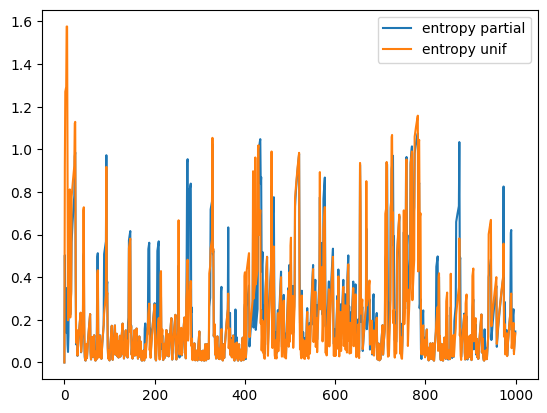

C:\Users\bura_al\AppData\Local\Temp\ipykernel_11992\3646236755.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


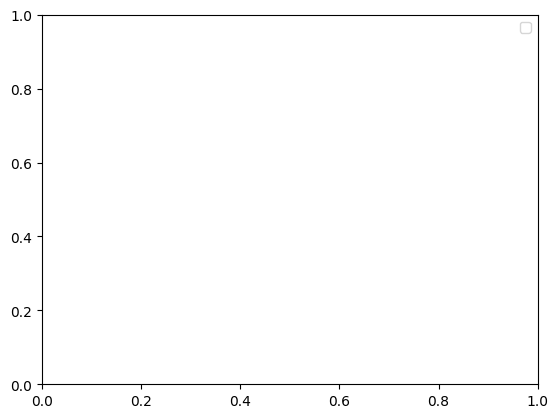

C:\Users\bura_al\AppData\Local\Temp\ipykernel_11992\3646236755.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


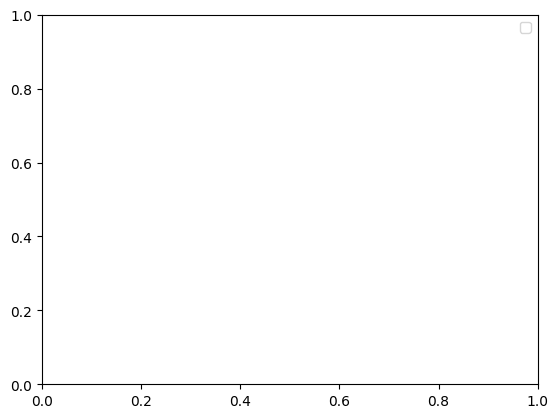

  0%|          | 0/16 [00:00<?, ?it/s]


ValueError: x and y must have same first dimension, but have shapes (16,) and (1,)

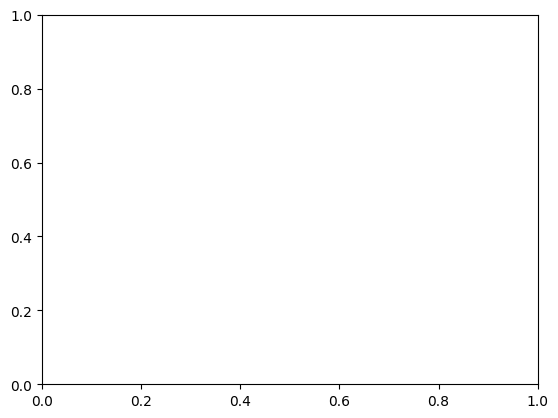

In [3]:
from hmm_joint_prob import run_hmm_simulation, run_hmm_simulation
from utils import SimulationParameters

from tqdm import tqdm
from copy import deepcopy
import math
import numpy as np

uniform_params = SimulationParameters(
        q=0.005,
        eta=1,
        zeta=5e-3, # Example: list of base probabilities. NodeDistribution will use this.
        epsilon=0.1,
        rho=0.05,
        m_override=None,
        K=2, # Initial K for the first plot
        alpha=0.02,
        beta=0, # Default beta, will be overridden in the loop
        R_unit=10,
        X_symbols=[0,1,2],
        Y_symbols=[0,1,2,3],
    )

import matplotlib.pyplot as plt
avg_unif, avg_gau_large, avg_gau_thin = [], [], []
avg_test = []
loc_aware_multi, loc_aware_bin = [], []
sim_length =1000
min_k = 4
for k in tqdm(range(min_k,20)):
    uniform_params.K = k
    uniform_params.m = math.floor(uniform_params.rho * np.pi * (uniform_params.K*uniform_params.R_unit)**2)
    test_params = deepcopy(uniform_params)
    test_params.noise_distribution = "diagonal"
    gaussian_params_1 = deepcopy(uniform_params)
    gaussian_params_1.noise_distribution = "partial_uniform"
    gaussian_params_1.base_sigma = 6
    gaussian_params_2 = deepcopy(gaussian_params_1)
    gaussian_params_2.base_sigma = 1

    print("Uniforme")
    entropy_evol_unif, avg_entropy_unif, _, _, _ = run_hmm_simulation(uniform_params, sim_length, seed=0, non_binary=True)
    #entropy_evol_diag, avg_entropy_test, _, _, _ = run_hmm_simulation(test_params, sim_length, seed=0, non_binary=True)
    _, avg_entropy_gau_1, _, _, _ = run_hmm_simulation(gaussian_params_1, sim_length, seed=0, non_binary=True)
    print("\n\n\n Gaussiana")
    entropy_evol_partial, avg_entropy_gau_2, _, _, _ = run_hmm_simulation(gaussian_params_2, sim_length, seed=0, non_binary=True)

    bin_params = deepcopy(uniform_params)
    bin_params.X_symbols = [0,1]
    bin_params.Y_symbols = [i for i in range(len(bin_params.X_symbols) * k + 1)]
    multi_params = deepcopy(uniform_params)
    multi_params.Y_symbols = [i for i in range(len(multi_params.X_symbols) * k + 1)]
    #_, avg_entropy_bin, _, _, _ = run_hmm_simulation(bin_params, sim_length, seed=0, non_binary=False, loc_aware=True)
    #_, avg_entropy_multi, _, _, _ = run_hmm_simulation(multi_params, sim_length, seed=0, non_binary=True, loc_aware=True)

    print(f"Entropy unif: {avg_entropy_unif}")
    avg_unif.append(avg_entropy_unif)
    #avg_test.append(avg_entropy_test)
    #avg_gau_large.append(avg_entropy_gau_1)
    avg_gau_thin.append(avg_entropy_gau_2)
    print(f"Entropy gaus: {avg_entropy_gau_2}")

    #loc_aware_bin.append(avg_entropy_bin)
    #loc_aware_multi.append(avg_entropy_multi)

    #plt.semilogy(entropy_evol_unif, label="entropy unif")
    plt.plot(entropy_evol_partial, label="entropy partial")
    plt.plot(entropy_evol_unif, label="entropy unif")
    plt.legend()
    plt.show()
    plt.legend()
    plt.show()
    plt.legend()
    plt.show()
    break

plt.figure(0)
plt.plot(np.arange(min_k, 20), avg_unif, label="uniform noise")
plt.plot(np.arange(min_k, 20), avg_test, label="no noise")
plt.plot(np.arange(min_k, 20), avg_gau_large, label=r"gaussian noise, $\sigma=1$")
plt.plot(np.arange(min_k, 20), avg_gau_thin,linestyle=":", label=r"gaussian noise, $\sigma=0.1$")
plt.legend()
plt.xlabel("Number of regions (K)")
plt.ylabel("average estimation entropy")
plt.grid(True)
plt.show()

plt.figure(1)

plt.plot(np.arange(min_k, 20), loc_aware_bin, label="2 symbols loc aware")
plt.plot(np.arange(min_k, 20), loc_aware_multi, label="6 symbols loc aware")
plt.plot(np.arange(min_k, 20), avg_unif, linestyle=":", label="6 symbols")
plt.xlabel("Number of regions (K)")
plt.ylabel("average estimation entropy")
plt.grid(True)
plt.legend()
plt.show()



In [5]:
p = np.array([0.9,0.05,0.05])
p2 = np.array([0.9,0.025,0.025,0.025,0.025])

print(f"Entropy p: {-np.sum(p*np.log2(p))}")
print(f"Entropy p2: {-np.sum(p2*np.log2(p2))}")

Entropy p: 0.5689955935892812
Entropy p2: 0.6689955935892812


C:\Users\bura_al\AppData\Local\Temp\ipykernel_20024\3351435466.py:7: RuntimeWarning: divide by zero encountered in divide
  sigma = np.sqrt(1/np.log(lam/(1-lam)))/np.sqrt(2)
C:\Users\bura_al\AppData\Local\Temp\ipykernel_20024\3351435466.py:8: RuntimeWarning: divide by zero encountered in divide
  prob_eq = 1/(1+np.exp(1/(2*sigma**2)))


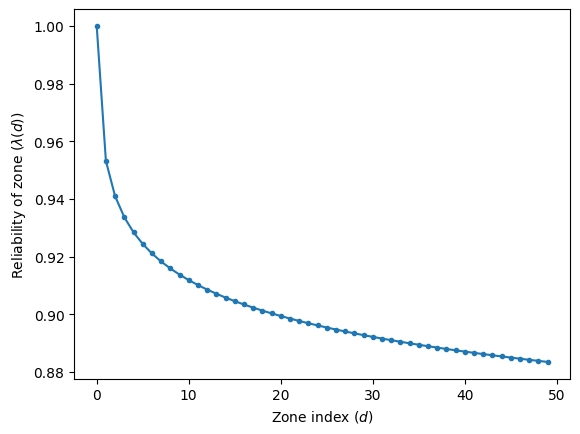

In [7]:
import numpy as np
R=10
K=50
alpha=0.02
lam = [1/(1+d*R)**alpha for d in range(0,K)]
lam = np.array(lam)
sigma = np.sqrt(1/np.log(lam/(1-lam)))/np.sqrt(2)
prob_eq = 1/(1+np.exp(1/(2*sigma**2)))

#gaussian


import matplotlib.pyplot as plt

plt.plot(lam, marker = '.')
#plt.plot(sigma, marker='x')
#plt.plot(prob_eq, marker='d', linestyle=':')
plt.ylabel(r"Reliability of zone ($\lambda(d)$)")
plt.xlabel(r"Zone index ($d$)")
plt.show()

P(0) = 0.5703
P(1) = 0.3459
P(2) = 0.0772
P(3) = 0.0063
P(4) = 0.0002


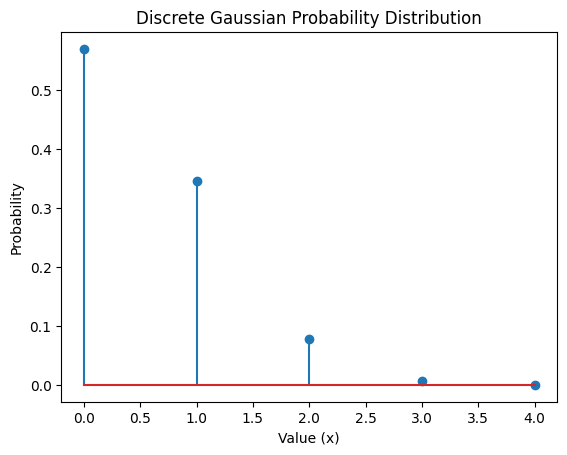

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the discrete set of values
x_values = np.arange(0, 5)  # From -5 to 5

# Mean and standard deviation for the Gaussian distribution
mu = 0
sigma = 1

# Calculate the Gaussian probability for each x
raw_probabilities = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x_values - mu)**2 / (2 * sigma**2))

# Normalize the probabilities so that they sum to 1
normalized_probabilities = raw_probabilities / np.sum(raw_probabilities)

# Display the probabilities
for x, p in zip(x_values, normalized_probabilities):
    print(f"P({x}) = {p:.4f}")

# Plot the probability distribution
plt.stem(x_values, normalized_probabilities)
plt.title("Discrete Gaussian Probability Distribution")
plt.xlabel("Value (x)")
plt.ylabel("Probability")
plt.show()

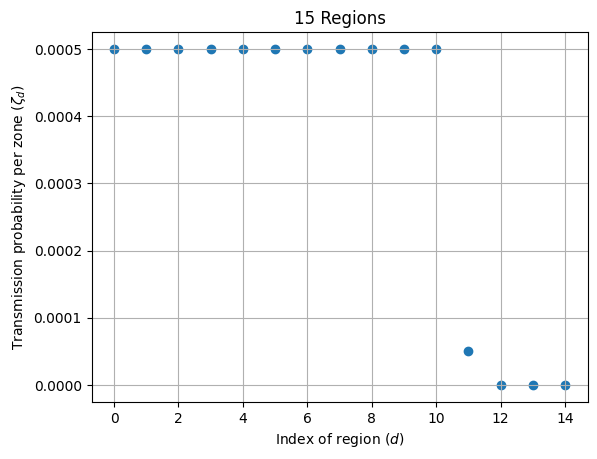

In [11]:
import matplotlib.pyplot as plt
import numpy as np

xs = np.arange(0,15)

probs = [5e-4]*11 + [5e-5] +[0]*3
plt.scatter(xs, probs)
plt.grid(True)
plt.ylabel(r"Transmission probability per zone ($\zeta_d$)")
plt.xlabel(r"Index of region ($d$)")
plt.title("15 Regions")
plt.show()